# Tutorial Notebook for nisarhdf.nisarRUNWHDF
---

This notebook demonstrates the functionality of `nisarRUNWHDF`, which is at tool for reading NISAR **RUNW** products.  Some of its functionality is specifically developed for the Greenland Mapping Project (GrIMP) workflows, but it may also be of general use for working with these products. If nothing else, the source code provides examples of how to unpack these projects.

## Installation

The easiest way to ensure the code works is to create a custom environment using the *environment.yml* file included in this *nisarhdf* repository. To do so execute the following,

`conda env create -f environment.yml`

Then setup the kernel for the Jupyter notebooks with the command:

`python -m ipykernel install --user --name=nisarcryo`

Then activate the environment:

`conda activate nisarcryo`

Finally, start Jupyter and open the notebooks.

**Even if you want to work with your existing environment, the *environment.yml* file demonstrates which packages must be installed if they are not already present.**


## Python Imports

In [1]:
%load_ext autoreload
%autoreload 2
import nisarhdf
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rioxarray
from osgeo import gdal

In [2]:
def autoScaleRange(myVar, percentile):
        '''
        If percentile less than 100, will select vmin as (100-percentile)
        and vmax as percentile of myVar, unless they fall out of the vmin and
        vmax bounds.
        Parameters
        ----------
        myVar : nparray
            Data being displayed.
        vmin : float
            Absolute minimum value.
        vmax : TYPE
            absolute maximum value.
        percentile : TYPE
            Clip data at (100-percentile) and percentile.

        Returns
        -------
        vmin, vmax - updated values based on percentiles.
        '''
        vmax = np.percentile(myVar[np.isfinite(myVar)], percentile)
        vmin = np.percentile(myVar[np.isfinite(myVar)], 100 - percentile)
        return vmin, vmax

In [3]:
def createDivider(ax, colorBarPosition='right', colorBarSize='5%',
                   colorBarPad=0.05):
    '''
    Create divider for color bar
    '''
    divider = make_axes_locatable(ax)  # Create space for colorbar
    return divider.append_axes(colorBarPosition, size=colorBarSize,
                               pad=colorBarPad)

def colorBar(pos, ax, colorBarLabel, colorBarPosition, colorBarSize,
              colorBarPad, labelFontSize, plotFontSize, extend='max',
              fontScale=1):
    '''
    Color bar for image
    '''
    # Create an divided axis for cb
    cbAx = createDivider(ax, colorBarPosition=colorBarPosition,
                             colorBarSize=colorBarSize,
                               colorBarPad=colorBarPad)
    # Select orientation
    orientation = {'right': 'vertical', 'left': 'vertical',
                   'top': 'horizontal',
                   'bottom': 'horizontal'}[colorBarPosition]

    cb = plt.colorbar(pos, cax=cbAx, orientation=orientation,
                      extend=extend)
    cb.set_label(colorBarLabel, size=labelFontSize * fontScale)
    cb.ax.tick_params(labelsize=plotFontSize * fontScale)
    if colorBarPosition in ['right', 'left']:
        cbAx.yaxis.set_ticks_position(colorBarPosition)
        cbAx.yaxis.set_label_position(colorBarPosition)
    elif colorBarPosition in ['top', 'tottom']:
        cbAx.xaxis.set_ticks_position(colorBarPosition)
        cbAx.xaxis.set_label_position(colorBarPosition)

## Open the HDF

Edit the path below to point to the ROFF product you wish to work with.

In [4]:
RUNWFile = '/Volumes/insar1/ian/NISAR/frame_280/insar/products/RUNW_ALOS2496725280-230804_ALOS2498795280-230818.h5'

Create an instance and open the hdf as shown below. For normal products, you shouldn't have to specify the orbit, but while the orbit fields are present in the example file, they are not populated. When you open the hdf, you can specify the precise orbit XMLs if desired, which are release a few weeks after the MOI orbits used in the processing.

In [5]:
myRUNW= nisarhdf.nisarRUNWHDF()
myRUNW.openHDF(RUNWFile , referenceOrbitXML=None, secondaryOrbitXML=None,
               referenceOrbit=49672, secondaryOrbit=49879, frame=5280)
myRUNW.SLCAzimuthPixelSize

ref orbit None
RUNW referenceZeroDopplerStartTime
alongTrackOffset
(1996, 857)
slantRangeOffset
(1996, 857)
correlationSurfacePeak
(1996, 857)
<class 'nisarhdf.nisarBaseHDF.pixelOffsets'>
[660125.35575111]
ref orbit None
Cannot sread secondary orbit yet
RUNW secondaryZeroDopplerStartTime
[660048.00413857]


2.2716394524093184

## RUNW Parameters

A summary of some of the more important parameters for the **RUNW** products can be obtained by.

In [6]:
myRUNW.printParams()

RUNW.referenceOrbit = 49672 
RUNW.frame = 5280 
RUNW.datetime = 2023-08-04 14:57:47.166045 
RUNW.referenceGranule = rslc_ALOS2496725280-230804.h5 
RUNW.SLCNearRange = 814637.0 
RUNW.SLCFarRange = 852284.282920905 
RUNW.SLCFirstZeroDopplerTime = 53867.166045 
RUNW.SLCLastZeroDopplerTime = 53877.165933569675 
RUNW.secondaryOrbit = 49879 
RUNW.secondaryDatetime = 2023-08-18 14:57:47.171967 
RUNW.secondaryGranule = rslc_ALOS2498795280-230818.h5 
RUNW.LookDirection = right 
RUNW.PassType = descending 
RUNW.Wavelength = 0.23840349999999996 
RUNW.PRF = 3051.234 
RUNW.epsg = 3031 
RUNW.NumberRangeLooks = 34 
RUNW.NumberAzimuthLooks = 34 
RUNW.MLRangeSize = 774 
RUNW.MLAzimuthSize = 897 
RUNW.MLRangePixelSize = 48.63435614235999 
RUNW.MLAzimuthPixelSize = None
RUNW.MLZeroDopplerTimeSpacing = 0.01114303262221121 
RUNW.MLNearRange = 814660.6019669514 
RUNW.MLFirstZeroDopplerTime = 53867.17145264818 
RUNW.MLIncidenceCenter = 39.84732481149274 

Data Fields
RUNW.coherenceMagnitude
RUNW.connectedCom

For GrIMP, we extract all of the parameters needed to process and geocode the data, which are saved in geojson format. All parameters are releative to the reference image (`myRUNW.secondary.getGeojson()` provides equivalent information for the secondary). Most of the parameters below are self explanatory. Here are a few definitions:

 - `nominalTime` is the time of the first record in the SLC.
 - `TimeToFirstSLCSample` for NISAR this is always 0.0 (older custom processed images could have a different value).
 - `SkewOffset`, `Squint`, and `deltaT` are other time corrections in seconds that are always 0. for NISAR and are maintained for backwards compatability.
 - `CorrectedTime` gives the time to the first ML look sample in the unwrapped product.

All this information except the geometry information is available as a dictionary (`myRUNW.geodatDict`)

In [7]:
print(myRUNW.getGeojson())

{
  "type":"Feature",
  "geometry": {
    "type":"Polygon",
    "coordinates": [[[-76.494402, -106.59151], [-76.768284, -108.995359], [-76.289652, -109.933962], [-76.024864, -107.591063], [-76.494402, -106.59151]]]
  },
  "properties": {
    "ImageName":"RUNW_ALOS2496725280-230804_ALOS2498795280-230818.h5",
    "Date":"2023-08-04",
    "NominalTime":"14:57:47.171450",
    "NumberRangeLooks": 34,
    "NumberAzimuthLooks": 34,
    "MLRangeSize": 774,
    "MLAzimuthSize": 897,
    "PRF": 3051.234,
    "MLNearRange": 814660.6019669514,
    "MLCenterRange": 833457.7806159735,
    "MLFarRange": 852254.9592649956,
    "RangeErrorCorrection": 0.0,
    "LookDirection":"right",
    "PassType":"descending",
    "CenterLatLon": [-76.39304245354971, -108.28401511969665],
    "TimeToFirstSLCSample": 0.0,
    "SkewOffset": 0.0,
    "Squint": 0.0,
    "EarthRadiusMajor": 6378137.0,
    "EarthRadiusMinor": 6356752.3142,
    "MLIncidenceCenter": 39.84732481149274,
    "SpaceCraftAltitude": 660125.355751

## Display Data

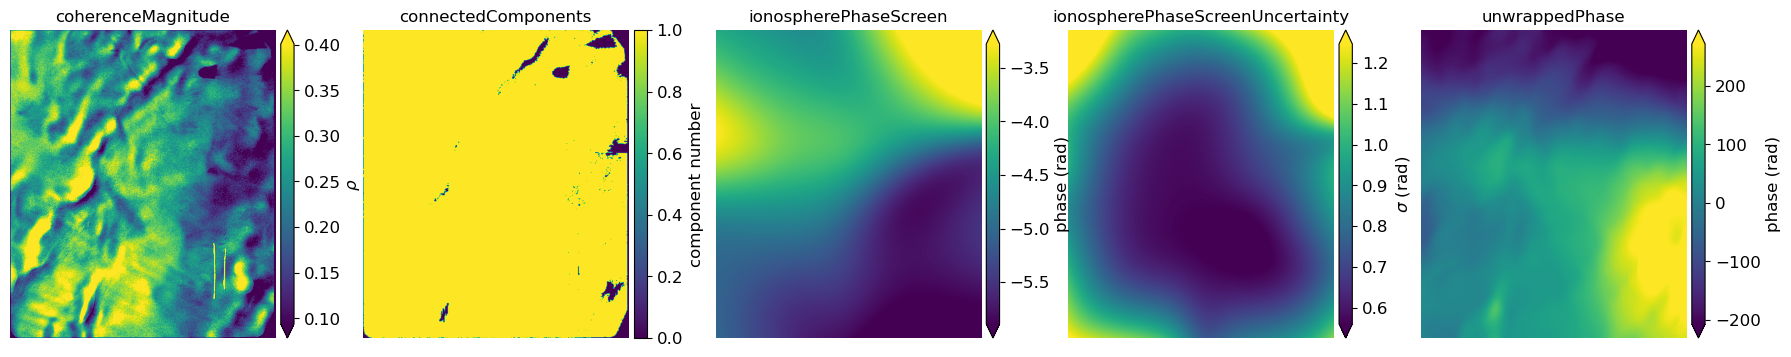

In [8]:
fields = myRUNW.dataFields[0:-1] 
labels = dict(zip(fields, ['$\\rho$', 'component number', 'phase (rad)', '$\\sigma$ (rad)', 'phase (rad)']))
fig, axes = plt.subplots(1, len(fields), figsize=(22, 4))
for field, ax in zip(fields, axes.flatten()):
    data = getattr(myRUNW, field)
    vmin, vmax = autoScaleRange(data, 95)
    if field not in ['connectedComponents']:
        h = ax.imshow(data, vmin=vmin, vmax=vmax, origin='lower')
        colorBar(h, ax, labels[field], 'right', '5%',.05, 12, 12, extend='both')
    else:
        h = ax.imshow(data, origin='lower')
        colorBar(h, ax, labels[field],'right', '5%',.05, 12, 12, extend='neither')
    ax.set_title(field)
    ax.axis('off')

## Masking 

### Connected Components Masking

In general, the areas where the connected components are zero have data of questionable quality and its often better to mask them. 

In [9]:
myRUNW.maskPhase(largest=True)

20841
smallLabels []


For this plot, we include the zero Doppler and slant range coordinates. Since we are viewing the product as increasing with time, the parameter `origin='lower'` is used. As a result, we need the extent for the lower-left corner, which is set as `extent=myRUNW.extentLL`.

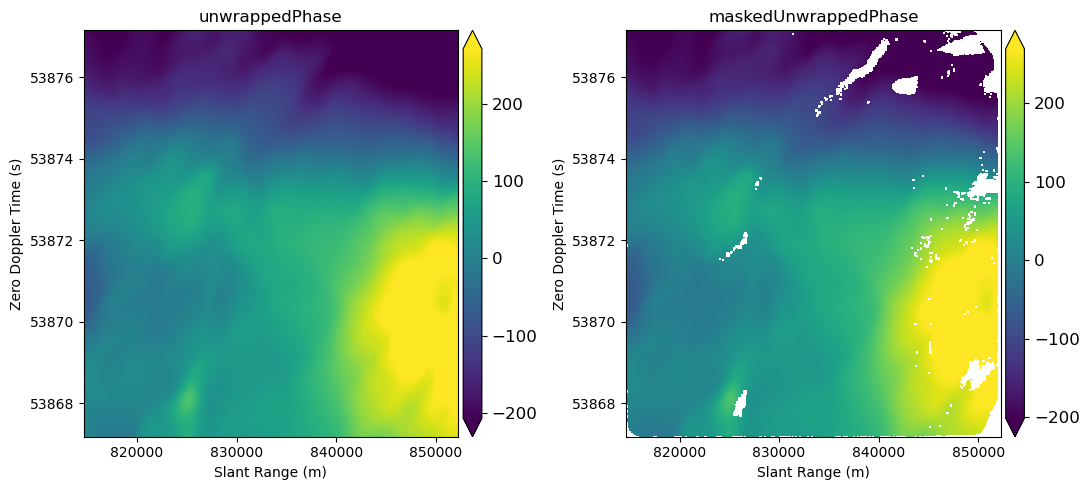

In [10]:
fields = ['unwrappedPhase', 'maskedUnwrappedPhase']
fig, axes = plt.subplots(1, len(fields), figsize=(11, 5))
for field, ax in zip(fields, axes.flatten()):
    data = getattr(myRUNW, field) 
    vmin, vmax = autoScaleRange(data, 95)
    h = ax.imshow(data, vmin=vmin, vmax=vmax, extent=myRUNW.extentLL, aspect='auto', origin='lower')
    colorBar(h, ax, '', 'right', '5%',.05, 12, 12, extend='both')
    ax.locator_params(axis='x', nbins=4)
    ax.set_title(field)
    ax.set_xlabel('Slant Range (m)')
    ax.set_ylabel('Zero Doppler Time (s)')
fig.tight_layout()

### Mask File

Its often useful to apply a mask from elsewhere. For example, a water mask. If the mask is saved with the same geometry as the unwrapped phase, this can be done with `myRUNW.applyMask`. As an example, the following will make a mask fild based on the correlation.

In [11]:
mask = np.ones(myRUNW.unwrappedPhase.shape, dtype='u1')
mask[myRUNW.coherenceMagnitude < 0.15] = 0
with open('mask', 'w') as fpOut:
    mask.tofile(fpOut)
drv = gdal.GetDriverByName("VRT")
vrt = drv.Create('mask.vrt', myRUNW.MLRangeSize, myRUNW.MLAzimuthSize, bands=0, eType=gdal.GDT_Byte)
vrt.SetGeoTransform([-0.5, 1., 0., -0.5, 0., 1.])
options = [f"SourceFilename=mask", "relativeToVRT=1", "subclass=VRTRawRasterBand"]
vrt.AddBand(gdal.GDT_Byte, options=options)
band = vrt.GetRasterBand(1)
vrt = None

Now the mask can be applied as shown below. Note if a mask as already been applied as in the example above, this masking will be combined with the prior mask.

In [12]:
myRUNW.applyMask('mask.vrt')

Here is the result.

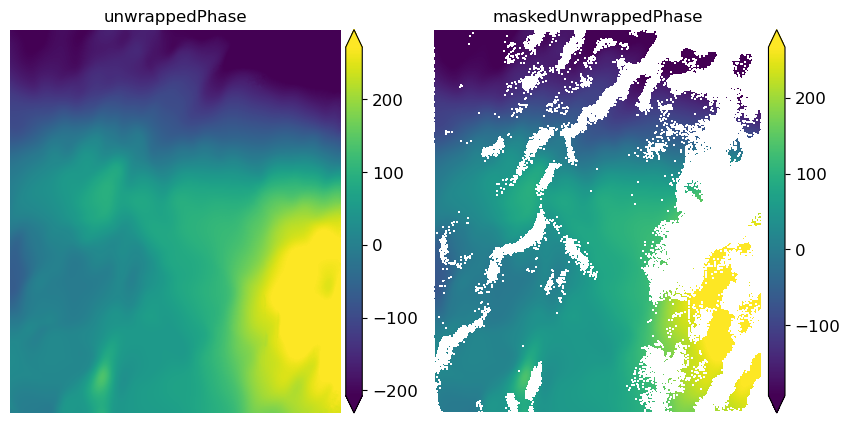

In [13]:
fields = ['unwrappedPhase', 'maskedUnwrappedPhase']
fig, axes = plt.subplots(1, len(fields), figsize=(10, 5))
for field, ax in zip(fields, axes.flatten()):
    data = getattr(myRUNW, field) 
    vmin, vmax = autoScaleRange(data, 95)
    h = ax.imshow(data, vmin=vmin, vmax=vmax, origin='lower')
    colorBar(h, ax, '', 'right', '5%',.05, 12, 12, extend='both')
    ax.set_title(field)
    ax.axis('off')

## Ionosphere Correction

The ionosphere phase screen can removed from either the masked or unmasked unwrapped phase.

In [14]:
myRUNW.ionosphereCorrectPhase(masked=True)

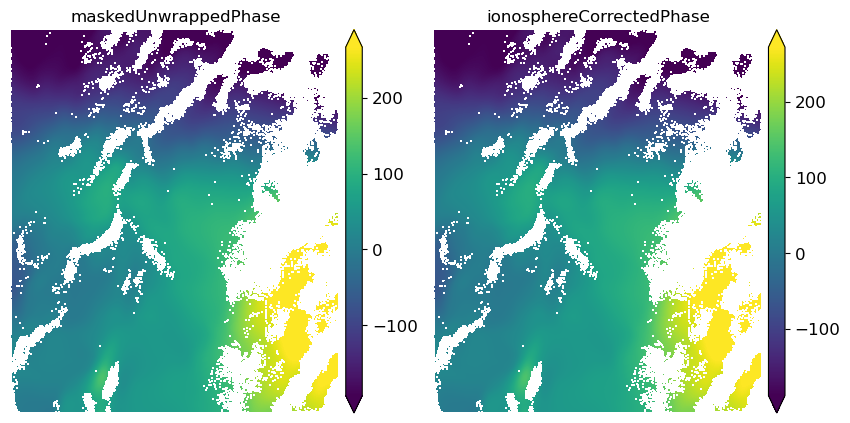

In [15]:
fields = ['maskedUnwrappedPhase', 'ionosphereCorrectedPhase']
fig, axes = plt.subplots(1, len(fields), figsize=(10, 5))
for field, ax in zip(fields, axes.flatten()):
    data = getattr(myRUNW, field) 
    vmin, vmax = autoScaleRange(data, 95)
    h = ax.imshow(data, vmin=vmin, vmax=vmax, origin='lower')
    colorBar(h, ax, '', 'right', '5%',.05, 12, 12, extend='both')
    ax.set_title(field)
    ax.axis('off')

## Metadata Interpolation

Much of the spatially dependent information (e.g., incidenceAngle) is stored at meta data cubes (see nisar documenation). These cubes can be interpolatated to obtain the slantRange, alongTrack, and elevation dependent results. Here are examples of how to extract these data for the offset grids.

In each case, an interpolator is setup. Once the setup has occurred, you can interpolated `myRUNW.interpolatorCubeName([[z, zeroDopplerTime, slantRange]])`. Interpolating to a grid can be acomplished by `myRUNW.interpGrid(myRUNW.interpolatorCubeName, zGrid, zeroDopplerGrid, slantRangeGrid)`.

**Note for speed when they are not needed, most of the interpolators and grids need to be explicitly initialized before use as shown below**

### Setup Grid for the Offsets

The R/D products include the DEM, which can be extracted as:

In [16]:
z = myRUNW.digitalElevationModel

Next, a range/Dopper grid corresponding to the offset maps is created.

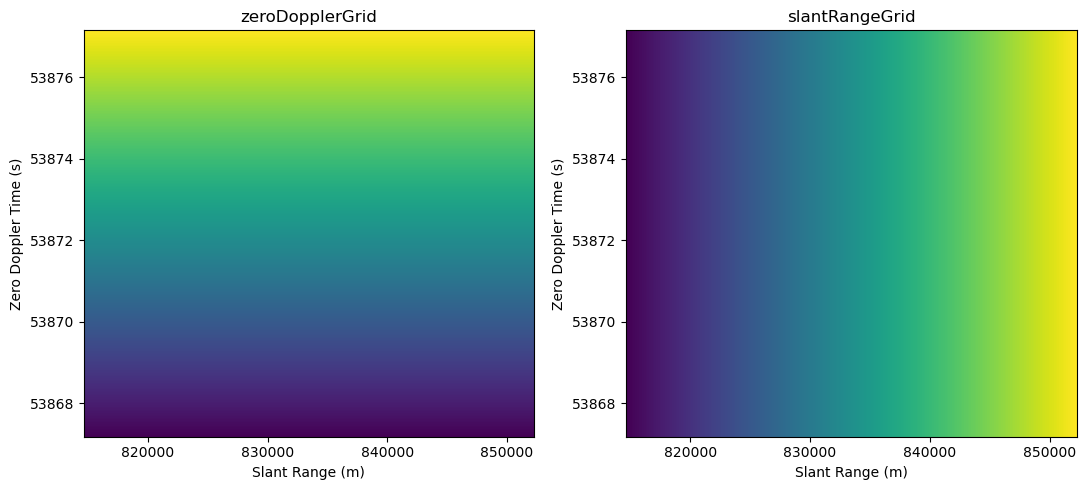

In [17]:
myRUNW.setupRangeDopplerGrid()
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
axes[0].imshow(myRUNW.zeroDopplerGrid, origin='lower', extent=myRUNW.extentLL, aspect='auto')
axes[1].imshow(myRUNW.slantRangeGrid, origin='lower', extent=myRUNW.extentLL, aspect='auto')
for ax, field in zip(axes, ['zeroDopplerGrid', 'slantRangeGrid']):
    ax.locator_params(axis='x', nbins=4)
    ax.set_title(field)
    ax.set_xlabel('Slant Range (m)')
    ax.set_ylabel('Zero Doppler Time (s)')
fig.tight_layout()

### Incidence and Elevation Angles

The incidence and elevation angles can be computed as follows:

incidenceAngle min/max: 37.957 41.593
elevationAngle min/max: 33.885 36.995


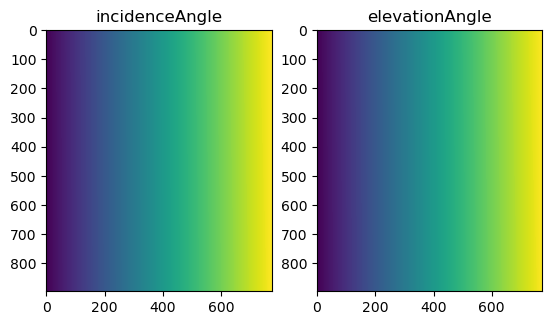

In [18]:
incidenceAngle = myRUNW.incidenceAngleCube(myRUNW.slantRangeGrid, myRUNW.zeroDopplerGrid, z)
elevationAngle = myRUNW.elevationAngleCube(myRUNW.slantRangeGrid, myRUNW.zeroDopplerGrid, z)
fig, axes = plt.subplots(1, 2)
for ax, var, title in zip(axes.flatten(), [incidenceAngle, elevationAngle], ['incidenceAngle', 'elevationAngle']):
    ax.imshow(var, origin='upper')
    ax.set_title(title)
    print(f'{title} min/max: {np.nanmin(var):.3f} {np.nanmax(var):.3f}')

### Ground Track Velocity

The ground track velocty is found by:

groundTrackVelocity min/max: 6859.976 6864.837


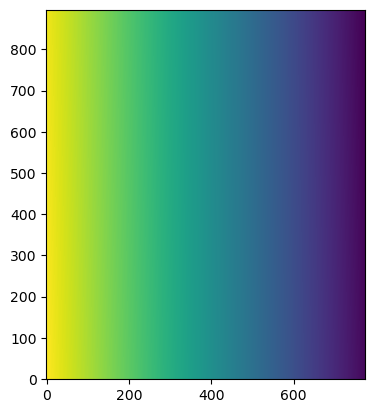

In [19]:
groundTrackVelocity=  myRUNW.groundTrackVelocityCube(myRUNW.slantRangeGrid, myRUNW.zeroDopplerGrid, z)
fig, ax = plt.subplots(1,1)
ax.imshow(groundTrackVelocity, origin='lower')
print(f'groundTrackVelocity min/max: {np.min(groundTrackVelocity):.3f} {np.max(groundTrackVelocity):.3f}')

### XY Values in the Projected Coordinate System

The `x` and `y` coordinate at corresponding to each slantRange and zeroDopplerTime coordiantes can be determined as:

$X_{3031}$ Grid min/max: -1454356.331 -1365200.137
$Y_{3031}$ Grid min/max: -510220.374 -420887.907


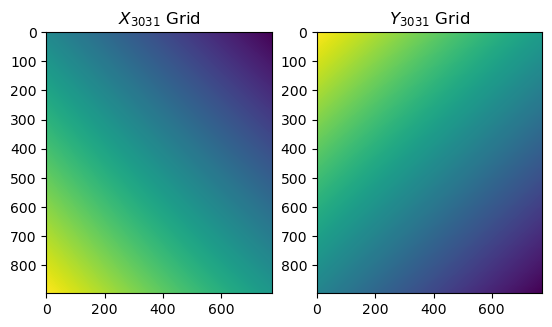

In [20]:
x, y =  myRUNW.xyCube(myRUNW.slantRangeGrid, myRUNW.zeroDopplerGrid, z)
fig, axes = plt.subplots(1, 2)
for ax, var, title in zip(axes.flatten(), [x, y], [f'$X_{{{myRUNW.epsg}}}$ Grid',f'$Y_{{{myRUNW.epsg}}}$ Grid']):
    ax.imshow(var, origin='upper')
    ax.set_title(title)
    print(f'{title} min/max: {np.nanmin(var):.3f} {np.nanmax(var):.3f}')

## Baseline Components

The perpendicular and parallel baseline components are computed as follows:

bn min/max: 91.112 96.560
bp min/max: 74.616 76.379


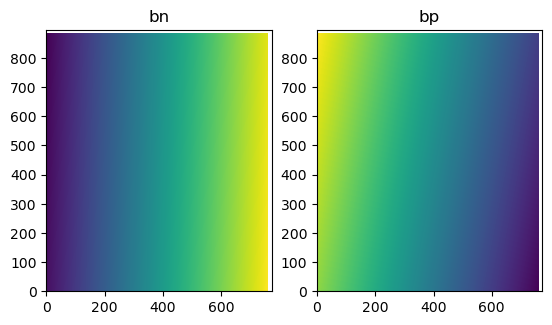

In [21]:
bn, bp =  myRUNW.baselineCube(myRUNW.slantRangeGrid, myRUNW.zeroDopplerGrid, z)
fig, axes = plt.subplots(1, 2)
for ax, var, title in zip(axes.flatten(), [bn, bp], ['bn', 'bp']):
    ax.imshow(var, origin='lower')
    ax.set_title(title)
    print(f'{title} min/max: {np.nanmin(var):.3f} {np.nanmax(var):.3f}')

### Along Track Unit Vector and LOS Unit Vector

The x and y components of the line-of-sight and along-track unit vector can be determined on the offset grid by:

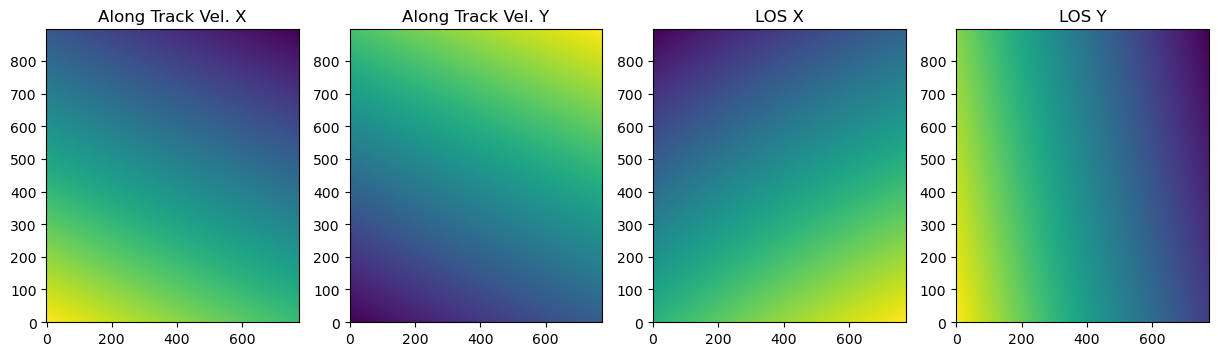

In [22]:
ATx, ATy =  myRUNW.alongTrackUnitVectorCube(myRUNW.slantRangeGrid, myRUNW.zeroDopplerGrid, z)
LOSx, LOSy=  myRUNW.losUnitVectorCube(myRUNW.slantRangeGrid, myRUNW.zeroDopplerGrid, z)
#
fig, axes = plt.subplots(1, 4, figsize=(15,5))
for ax, var, title in zip(axes.flatten(), [ATx, ATy, LOSx, LOSy], ['Along Track Vel. X', 'Along Track Vel. Y', 'LOS X', 'LOS Y']):
    ax.imshow(var, origin='lower')
    ax.set_title(title)

## Other Meta Data

Most of the essential meta data has been parsed and demonstrated in the examples above. Other quantities can be extracted by keyword from the h5 files. For example, the **centerFrequency** can be extracted as:

In [23]:
np.array(myRUNW.h5['RUNW']['metadata']['processingInformation']['inputs']['l1ReferenceSlcGranules']).item().decode()

'rslc_ALOS2496725280-230804.h5'

Note in the above example, `h5` has bypassed the `science` and `LSAR` levels for brevity. To access the h5 object from the the top, use `myRUNW.h5Full`. See the NISAR documentation or open the h5 file with a viewer to see all of the data fields. 

## Save Data to Binary or Tiff Files.

The data from the hdf can be save as individual tiffs, bound together by a single vrt file. The default is to write all of the bands e.,g `'coherenceMagnitude', 'connectedComponents', 'ionospherePhaseScreen', 'ionospherePhaseScreenUncertainty',' and `'unwrappedPhase'` for a **RUNW** product, which is accomplished as follows.

In the previous example, the results were save as tiffs. To save as binary files, run with `tiff=False` for a more limited set of bands:

In [24]:
myRUNW.writeData('output/RUNWbinary', bands=['coherenceMagnitude', 'unwrappedPhase'], tiff=False)
!ls output/RUNWbinary*

output/RUNWbinary.coherenceMagnitude  output/RUNWbinary.vrt
output/RUNWbinary.unwrappedPhase


The data can be read back in as an `rioxarray`  using `nisarhdf.readVrtAsXarray`, which saves each band as a named data variable. The results can be displayed using the `xarray` version of `imshow`.

<xarray.Dataset>
Dimensions:             (x: 774, y: 897)
Coordinates:
  * x                   (x) float64 8.147e+05 8.147e+05 ... 8.522e+05 8.523e+05
  * y                   (y) float64 5.387e+04 5.387e+04 ... 5.388e+04 5.388e+04
    spatial_ref         int64 0
Data variables:
    coherenceMagnitude  (y, x) float32 0.01271 0.009629 ... 0.001383 0.003953
    unwrappedPhase      (y, x) float32 1.078 3.196 3.491 ... -252.8 -252.8
Attributes: (12/27)
    bands:                     ['coherenceMagnitude', 'unwrappedPhase']
    ByteOrder:                 LSB
    datetime:                  2023-08-04 14:57:47.166045
    epsg:                      3031
    frame:                     5280
    LookDirection:             right
    ...                        ...
    secondaryOrbit:            49879
    SLCFarRange:               852284.282920905
    SLCFirstZeroDopplerTime:   53867.166045
    SLCLastZeroDopplerTime:    53877.165933569675
    SLCNearRange:              814637.0
    Wavelength:                0.23840349999999996

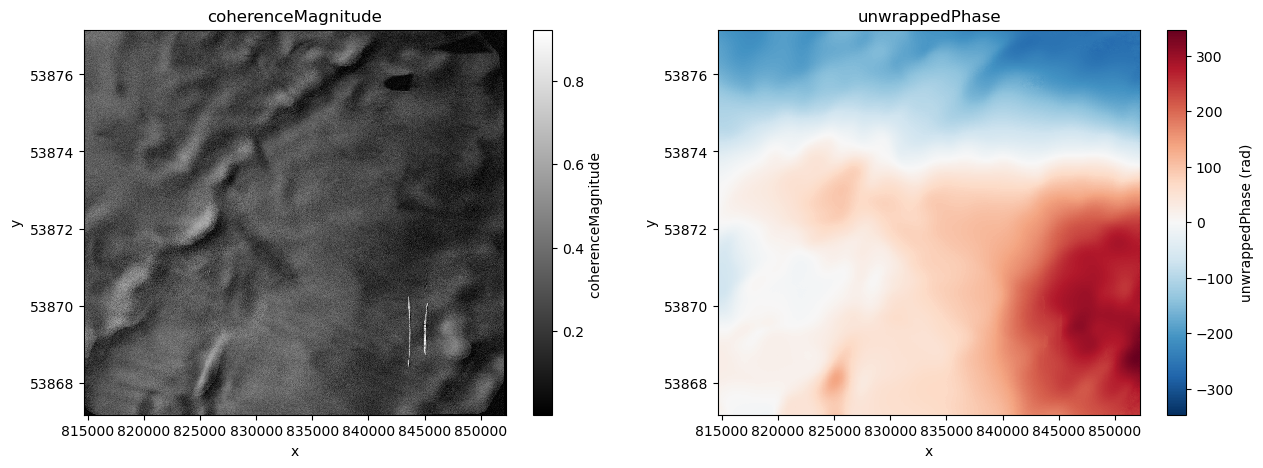

In [45]:
RUNWbinary = nisarhdf.readVrtAsXarray('output/RUNWbinary.vrt', mask_and_scale=True)
#extent = [np.min(RUNWbinary.x), np.max(RUNWbinary.x), np.min(RUNWbinary.y), np.max(RUNWbinary.y)
# Get the band names
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for var, ax, cmap, units in zip(RUNWbinary.data_vars, axes.flatten(), ['gray', 'RdBu_r'], ['', '(rad)']):
    RUNWbinary[var].plot.imshow(ax=ax, cmap=cmap, cbar_kwargs={'label': f'{var} {units}'})
    ax.set_title(var)
RUNWbinary

## Save Gridded Data Cubes

The gridded data cubes can also be saved as either flat binary or as cloud-optimized geotiff (COG) files. In this case, use `save=True` to save the result internally, and then use `writeData` to save data the same way the other bands are saved. In the example below, the data are saved as COGs.

In [26]:
myRUNW.incidenceAngleCube(myRUNW.slantRangeGrid, myRUNW.zeroDopplerGrid, z, save=True);
myRUNW.elevationAngleCube(myRUNW.slantRangeGrid, myRUNW.zeroDopplerGrid, z, save=True);
myRUNW.writeData('output/RUNWangles',bands=['incidenceAngle', 'elevationAngle'], tiff=True) # ', 'elevationAngle'

<xarray.Dataset>
Dimensions:         (x: 774, y: 897)
Coordinates:
  * x               (x) float64 8.147e+05 8.147e+05 ... 8.522e+05 8.523e+05
  * y               (y) float64 5.388e+04 5.388e+04 ... 5.387e+04 5.387e+04
    spatial_ref     int64 0
Data variables:
    incidenceAngle  (y, x) float32 37.96 37.96 37.97 37.97 ... 41.58 41.59 41.59
    elevationAngle  (y, x) float32 33.89 33.89 33.89 33.9 ... 36.99 36.99 36.99
Attributes: (12/27)
    bands:                     ['incidenceAngle', 'elevationAngle']
    ByteOrder:                 LSB
    datetime:                  2023-08-04 14:57:47.166045
    epsg:                      3031
    frame:                     5280
    LookDirection:             right
    ...                        ...
    secondaryOrbit:            49879
    SLCFarRange:               852284.282920905
    SLCFirstZeroDopplerTime:   53867.166045
    SLCLastZeroDopplerTime:    53877.165933569675
    SLCNearRange:              814637.0
    Wavelength:                0.23840349999999996

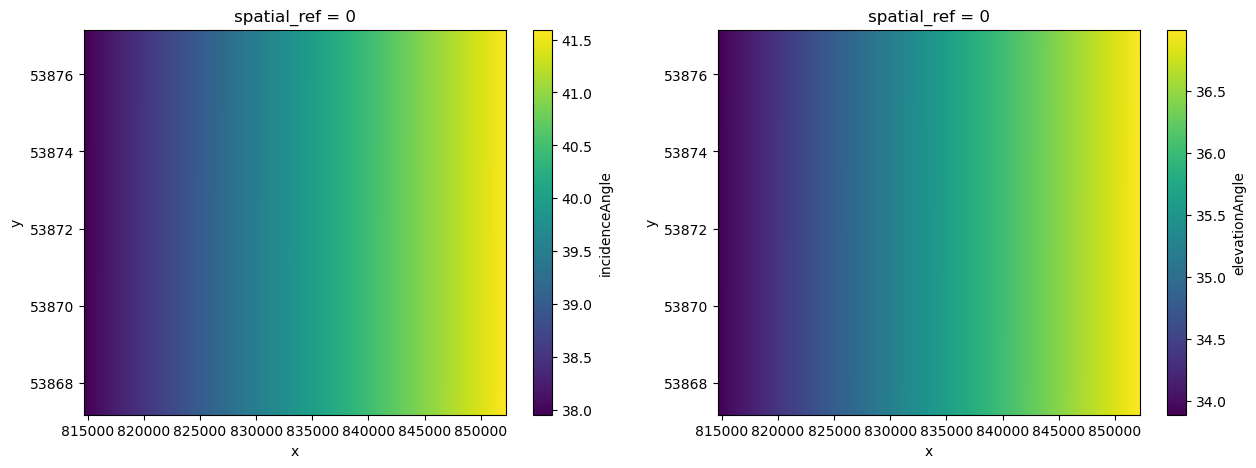

In [27]:
RUNWTiff = nisarhdf.readVrtAsXarray('output/RUNWangles.vrt', mask_and_scale=True)
#extent = [np.min(RUNWbinary.x), np.max(RUNWbinary.x), np.min(RUNWbinary.y), np.max(RUNWbinary.y)
# Get the band names
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
RUNWTiff.incidenceAngle.plot.imshow(ax=axes[0])
RUNWTiff.elevationAngle.plot.imshow(ax=axes[1])
RUNWTiff

# Anything below here is debug code that can be ignored